## Sparse point robot navigation
In this task, a point robot must navigate under sparse rewards to different locations on the x-y plane. Reward is zero outside the goal region, and shaped inside. The goal distribution is chosen to be the half unit circle.

This notebook is for visualizing rollouts collected from a learned policy.


For now, you must first train the policy.
 - edit `sparse-point-robot.json` to add `dump_eval_paths=1`
 - run `python launch_experiment.py ./configs/sparse-point-robot.json`

In [45]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pickle
import os
import colour
import glob

# config
root_dir = 'dir-new'
env_id = 'sparse-direction-point-robot'
dim, ncat, cdim, ddim, ndir, lam, tem, ann, unit, dc, cc, dic, a, c, ea, var, exp_id = \
    ['4', '5', '2', '0', '0', '50.0', '0.33', 'False', 'False', '0.0', '0.0', '0.0', 'None', 'None', 'None', 'None', '2019_09_08_18_33_19']
tlow, thigh = 20, 32 # task ID range 
small_goals = range(tlow, thigh)
# small_goals = [2,3,8,15,17]

# see `n_tasks` and `n_eval_tasks` args in the training config json 
# by convention, the test tasks are always the last `n_eval_tasks` IDs
# so if there are 100 tasks total, and 20 test tasks, the test tasks will be IDs 81-100
epoch = 299 # training epoch to load data from
gr = 0.2 # goal radius, for visualization purposes

expdir = '{}/{}/dim-{}-ncat-{}-cdim-{}-ddim-{}-ndir-{}-lam-{}-tem-{}-ann-{}-unit-{}-dc-{}-cc-{}-dic-{}-a-{}-c-{}-ea-{}-var-{}/seed-0/'\
        .format(root_dir, env_id, 
                    dim, ncat, cdim, ddim, ndir, lam, tem, ann, unit, dc, cc, dic, a, c, ea, var) # directory to load data from
all_dirs = glob.glob(os.path.join(expdir, '*'))
print (all_dirs)
expdir = os.path.join(all_dirs[0], 'eval_trajectories')
# {}/eval_trajectories
# helpers
def load_pkl(task):
    with open(os.path.join(expdir, 'task{}-epoch{}-run0.pkl'.format(task, epoch)), 'rb') as f:
        data = pickle.load(f)
    return data

def load_pkl_prior():
    with open(os.path.join(expdir, 'prior-epoch{}.pkl'.format(epoch)), 'rb') as f:
        data = pickle.load(f)
    return data

['dir-new/sparse-direction-point-robot/dim-4-ncat-5-cdim-2-ddim-0-ndir-0-lam-50.0-tem-0.33-ann-False-unit-False-dc-0.0-cc-0.0-dic-0.0-a-None-c-None-ea-None-var-None/seed-0/2019_09_08_18_38_39']


In [46]:
# paths = load_pkl_prior()
# print (len(paths))
# for i in paths:
#     print (i)

#### Trajectories sampled from the meta-learned prior
Over the course of training the distribution over the latent context variable is optimized to represent the task distribution. Samples from the prior should look relatively uniform - visually we should see trajectories of the agent navigating to all the goal regions.

In [47]:
# plt.figure(figsize=(8,8))
# axes = plt.axes()
# axes.set(aspect='equal')
# plt.axis([-1.25, 1.25, -0.25, 1.25])
# paths = load_pkl_prior()
# goals = [load_pkl(task)[0]['goal'] for task in range(tlow, thigh)]
# beg=8
# for g in goals[beg:beg+1]:
#     circle = plt.Circle((g[0], g[1]), radius=gr)
#     axes.add_artist(circle)
# for traj in paths[beg:beg+1]:
#     states = traj['observations']
#     plt.plot(states[:-1, 0], states[:-1, 1], '-o')
#     plt.plot(states[-1, 0], states[-1, 1], '-x', markersize=20)

# plt.savefig('./test-4.pdf')

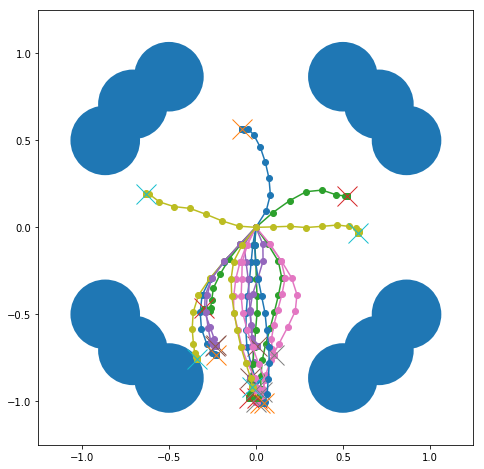

In [48]:
paths = load_pkl_prior()
goals = [load_pkl(task)[0]['goal'] for task in small_goals]

plt.figure(figsize=(8,8))
axes = plt.axes()
axes.set(aspect='equal')
plt.axis([-1.25, 1.25, -1.25, 1.25])
for g in goals:
    circle = plt.Circle((g[0], g[1]), radius=gr)
    axes.add_artist(circle)
rewards = 0
final_rewards = 0
for traj in paths:
    rewards += sum(traj['rewards'])
    final_rewards += traj['rewards'][-1]
    states = traj['observations']
    plt.plot(states[:-1, 0], states[:-1, 1], '-o')
    plt.plot(states[-1, 0], states[-1, 1], '-x', markersize=20)
# plt.savefig('./test-2.pdf')

#### Online adaptation trajectories
Online adaptation proceeds by posterior sampling: roll out a trajectory, add it to the pool of context seen so far in the task, update the posterior over the latent context variable via feed-forward inference, and sample a new latent context from the posterior. 
In this visualization, each figure shows the agent in a different task (goal region shown in dark blue). Early (dark) trajectories should resemble samples from the prior, while later (light) trajectories that are conditioned on more context should navigate to the correct goal.

12


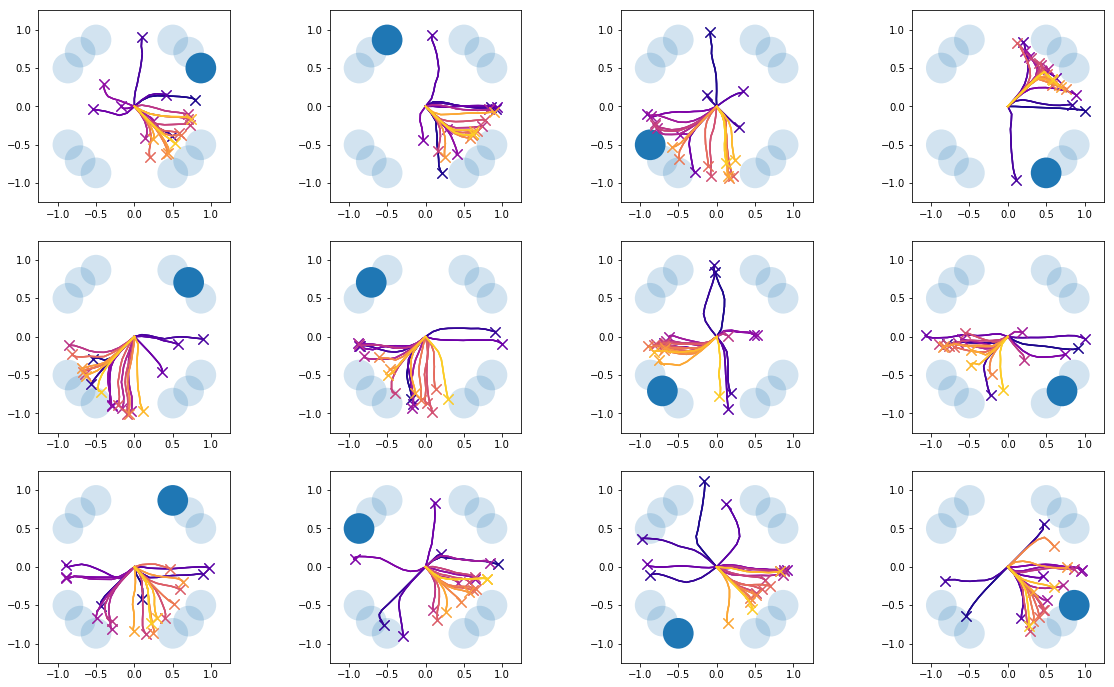

In [40]:
mpl = 20
num_trajs = 60

all_paths = []
for task in small_goals:
    paths = [t['observations'] for t in load_pkl(task)]
    all_paths.append(paths)

print (len(all_paths))
# color trajectories in order they were collected
cmap = matplotlib.cm.get_cmap('plasma')
sample_locs = np.linspace(0, 0.9, num_trajs)
colors = [cmap(s) for s in sample_locs]

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
t = 0
for j in range(4):
    for i in range(3): 
        axes[i, j].set_xlim([-1.25, 1.25])
        axes[i, j].set_ylim([-1.25, 1.25])
        for k, g in enumerate(goals):
            alpha = 1 if k == t else 0.2
            circle = plt.Circle((g[0], g[1]), radius=gr, alpha=alpha)
            axes[i, j].add_artist(circle)
        indices = list(np.linspace(0, len(all_paths[t]), num_trajs, endpoint=False).astype(np.int))
        counter = 0
        for idx in indices:
            states = all_paths[t][idx]
            axes[i, j].plot(states[:-1, 0], states[:-1, 1], '-', color=colors[counter])
            axes[i, j].plot(states[-1, 0], states[-1, 1], '-x', markersize=10, color=colors[counter])
            axes[i, j].set(aspect='equal')
            counter += 1
        t += 1
# plt.savefig('./test-cat-2.pdf')